In [121]:
import pandas as pd
import datetime as dt
from datetime import timedelta
from datetime import datetime
from numpy import random
from numpy import nan
import plotly.express as px


glob_random_state=100
random.seed(glob_random_state)
year=str('2019')

show_intermediate_results = True #True 

n_verkoop_order_df = 162 #random.randint(150,400)
n_klant_df = 25

In [122]:
dataframes_list = ['klant_df', 'verkoop_order_df', 'product_df', 'werkorder_df', 'machine_df',
                    'onderdelen_df', 'BOM_df', 'route_df']  

#  'woonplaatsen_df', 'achternamen_df',
# Removed from list. Only created as temporary results and deleted after join with klant_df

In [123]:
def create_dataframes(dataframes_list):
    for df in dataframes_list:
        vars()[df] = pd.DataFrame()

In [124]:
klant_df = pd.DataFrame(random.randint(0,100,size=(n_klant_df, 4)),  \
                        columns=['klant_id','klant_naam','klant_achternaam','klant_woonplaats'])
klant_df.index.rename('klant_id', inplace=True)


if show_intermediate_results == True:

    print(klant_df.head(10))

          klant_id  klant_naam  klant_achternaam  klant_woonplaats
klant_id                                                          
0                8          24                67                87
1               79          48                10                94
2               52          98                53                66
3               98          14                34                24
4               15          60                58                16
5                9          93                86                 2
6               27           4                31                 1
7               13          83                 4                91
8               59          67                 7                49
9               47          65                61                14


In [125]:
import xml.etree.ElementTree as et 

xtree = et.parse("fn_10kw.xml")
xroot = xtree.getroot()

df_columns=['achternaam', 'achternaam_los', 'voorvoegsel']
rows=[]

for node in xroot:
#     record = node.attrib.get("record")
#     naam = node.find("naam")  #.text if node is not None else None

    naam = ''
    achternaam_los = node.getchildren()[2].text if node is not None else None
    prefix = node.getchildren()[1].text if node is not None else None
    if prefix is not None:
        naam = achternaam_los+', '+prefix
    else: naam = achternaam_los
    
    rows.append({'achternaam':naam, 'achternaam_los':achternaam_los, 'voorvoegsel':prefix})

achternamen_df = pd.DataFrame(rows, columns=df_columns)
achternamen_df = achternamen_df.sample(len(klant_df))
achternamen_df.reset_index(inplace=True)
achternamen_df.index=klant_df['klant_achternaam']


voornamen_df = pd.read_csv('voornamen.txt', sep=';', skiprows=0, encoding='latin-1')
voornamen_df.columns=['geslacht','meet_jaar','maand','voornaam', 'rang']
voornamen_df = voornamen_df.sample(len(klant_df))
voornamen_df.reset_index(inplace=True)
voornamen_df.index=klant_df['klant_naam']


klant_df=klant_df.join(achternamen_df['achternaam'], on='klant_achternaam')
klant_df=klant_df.join(voornamen_df[['voornaam','geslacht']], on='klant_naam')
klant_df.drop(columns=['klant_achternaam','klant_naam'], inplace=True)
klant_df.drop_duplicates(subset=['klant_id','klant_woonplaats'], keep='first', inplace=True)

del voornamen_df, achternamen_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning:

This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.



In [130]:
woonplaatsen_df = pd.read_csv('Woonplaatsen_in_Nederland_2018_07042020_210926.csv', sep='";"', skiprows=3, encoding='UTF-8')
# Added , encoding='UTF-8' to prevent value 'Súdwest-Fryslân' in CSV being loaded as 'SÃºdwest-FryslÃ¢n'

woonplaatsen_df = woonplaatsen_df[1:]
new_column_names = list(woonplaatsen_df.columns)
new_column_names[0]='Woonplaats'
woonplaatsen_df.columns = new_column_names
 
woonplaatsen_df['Woonplaats'] = woonplaatsen_df['Woonplaats'].apply(lambda x: str(x).replace('"', '') )
woonplaatsen_df['Landsdeel|Code"'] = woonplaatsen_df['Landsdeel|Code"'].apply(lambda x: str(x).replace('"', '') )


# Take small sample of woonplaatsen_df and create new (incorrect) indexes (based on klant_df)
woonplaatsen_df=woonplaatsen_df.sample(len(klant_df))
woonplaatsen_df.reset_index(inplace=True)
woonplaatsen_df.index=klant_df['klant_woonplaats']


if show_intermediate_results == True:
    
    print(woonplaatsen_df.head(10) )

                  index     Woonplaats Gemeente|Naam  Gemeente|Code   \
klant_woonplaats                                                       
87                  805         Heeten         Raalte         GM0177   
94                 1861      Schoonloo      AaenHunze         GM1680   
66                  157   Beek en Donk       Laarbeek         GM1659   
24                  634       Gellicum   Geldermalsen         GM0236   
16                  506  Egmond-Binnen    Bergen(NH.)         GM0373   
2                  1522          Oirlo         Venray         GM0984   
1                  2329          Wijhe     Olst-Wijhe         GM1773   
91                 2317          Wezup      Coevorden         GM0109   
49                  384       Delfzijl       Delfzijl         GM0010   
14                  412       Doesburg       Doesburg         GM0221   

                 Provincie|Naam Provincie|Code   Landsdeel|Naam  \
klant_woonplaats                                                  
8

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [103]:
klant_df=klant_df.join(woonplaatsen_df[['Woonplaats', 'Gemeente|Naam ', 'Gemeente|Code ', 'Provincie|Naam']],\
              on='klant_woonplaats')
klant_df.drop(columns=['klant_woonplaats'], inplace=True)
klant_df=klant_df[~klant_df.duplicated(subset=['klant_id','achternaam'], keep='first')]
del woonplaatsen_df
klant_df

,klant_id,achternaam,voornaam,geslacht,Woonplaats,Gemeente|Naam,Gemeente|Code,Provincie|Naam
klant_id,,,,,,,,
0,93,"Gijzen, van",Quinn,M,Drijber,Midden-Drenthe,GM1731,Drenthe
1,16,Bernhard,Lukas,M,Waterlandkerkje,Sluis,GM1714,Zeeland
2,87,Selles,Luca,M,Europoort Rotterdam,Rotterdam,GM0599,Zuid-Holland
3,77,Doornekamp,Babette,V,Oosteind,Oosterhout,GM0826,Noord-Brabant
4,37,Zoeteman,Justin,M,Oosteind,Oosterhout,GM0826,Noord-Brabant
5,60,Özkan,Ramon,M,Zwiggelte,Midden-Drenthe,GM1731,Drenthe
6,56,Klaver,Rianne,V,Middenbeemster,Beemster,GM0370,Noord-Holland
7,87,Priester,Pim,M,Spanbroek,Opmeer,GM0432,Noord-Holland
8,89,Vrijsen,Aya,V,Sondel,DeFryskeMarren,GM1940,Friesland


In [62]:
# import modules
#import random
import datetime

# create function accepting a single parameter, the year as a four digit number
def get_random_date(year):
    
    calendar=pd.bdate_range(start='01-01-'+year, end='31-12-'+year)
    random_day=random.randint(0, 261)
    
    # try to get a date
    try:
#        return datetime.datetime.strptime('{} {}'.format(random.randint(1, 366), year), '%j %Y')
        return datetime.datetime.strptime(calendar[random_day].strftime('%Y-%m-%d') ,'%Y-%m-%d')

    # if the value happens to be in the leap year range, try again
    except ValueError:
        get_random_date(year)

In [63]:
verkoop_order_df = pd.DataFrame(data=(random.randint(0,25, size=(n_verkoop_order_df, 2))), columns=['klant_id','verkoop_order_datum'])
verkoop_order_df['verkoop_order_datum'] = verkoop_order_df['verkoop_order_datum'].apply(lambda x: get_random_date(year))
verkoop_order_df.sort_values(by='verkoop_order_datum', inplace=True)
verkoop_order_df.reset_index(drop=True, inplace=True)
verkoop_order_df.index.rename('verkoop_order_id', inplace=True)


if show_intermediate_results == True:
    print('n_verkoop_order_df : {}\n'.format(n_verkoop_order_df))
    print(verkoop_order_df.head(10))

n_verkoop_order_df : 158

                  klant_id verkoop_order_datum
verkoop_order_id                              
0                        1          2019-01-02
1                       14          2019-01-03
2                       11          2019-01-04
3                       14          2019-01-09
4                        1          2019-01-09
5                        1          2019-01-10
6                       13          2019-01-11
7                       20          2019-01-11
8                        9          2019-01-15
9                        2          2019-01-17


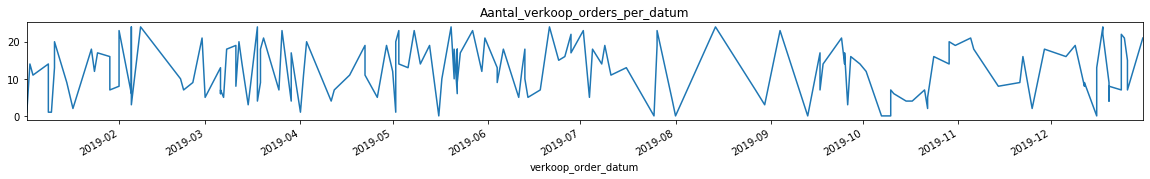

In [64]:
if show_intermediate_results == True:
    verkoop_order_df.plot(x='verkoop_order_datum', figsize=(20,2), legend=False, title='Aantal_verkoop_orders_per_datum', kind='line')

In [65]:
if show_intermediate_results == True:
#    verkoop_order_df.hist(column='klant_id', bins=10)
    fig=px.histogram(verkoop_order_df, x='verkoop_order_datum', nbins=12)
    fig.show()

In [66]:
if show_intermediate_results == True:
#    verkoop_order_df.hist(column='klant_id', bins=10)
    fig=px.histogram(verkoop_order_df, x='klant_id', nbins=10)
    fig.show()

In [67]:
product_verkoop_prijs_S, product_verkoop_prijs_M, product_verkoop_prijs_L = random.randint(50, 80, size=(3,1))
ratio_kp = 0.6

# Solve Issue #4 
product_data={                                             # Adding new product_id, requires to add bewerkingstijd() and BOM
 0:{'name':'Robot arm (S)',
    'revisie':'A',
    'kostprijs':float(product_verkoop_prijs_S),
    'verkoopprijs':float(product_verkoop_prijs_S*ratio_kp)},
 1:{'name':'Robot arm (M)',
    'revisie':'A',
    'kostprijs':float(product_verkoop_prijs_M),
    'verkoopprijs':float(product_verkoop_prijs_M*ratio_kp)},
 2:{'name':'Robot arm (L)',
    'revisie':'A',
    'kostprijs':float(product_verkoop_prijs_L),
    'verkoopprijs':float(product_verkoop_prijs_L*ratio_kp)},
 4:{'name':'Robot arm (L)',                                 # 'product_id' without a bill of material, for example purpose
    'revisie':'B',
    'kostprijs':float(product_verkoop_prijs_L),
    'verkoopprijs':float(product_verkoop_prijs_L*ratio_kp+17)},
3:{'name':'Robot arm (S)',
    'revisie':'B',
    'kostprijs':float(product_verkoop_prijs_S),
    'verkoopprijs':float(product_verkoop_prijs_S*ratio_kp+5)},
}


product_df = pd.DataFrame.from_dict(product_data, orient='index').reset_index()
product_df.columns = ['product_id','product_naam','revisie','product_verkoop_prijs','product_kost_prijs']

product_df.index.rename('product_id', inplace=True)
# product_df.drop('product_id', axis=1, inplace=True)

if show_intermediate_results == True:
    
    print(product_df.head(10) )

            product_id   product_naam revisie  product_verkoop_prijs  \
product_id                                                             
0                    0  Robot arm (S)       A                   57.0   
1                    1  Robot arm (M)       A                   52.0   
2                    2  Robot arm (L)       A                   69.0   
3                    4  Robot arm (L)       B                   69.0   
4                    3  Robot arm (S)       B                   57.0   

            product_kost_prijs  
product_id                      
0                         34.2  
1                         31.2  
2                         41.4  
3                         58.4  
4                         39.2  


In [68]:
# Solve issue #5
# # Opnieuw vullen van 'product_id' met de nieuwe id zoals ze gecreeerd zijn in product_df
# verkoop_order_df['product_id'] = verkoop_order_df['verkoop_order_datum'].apply(\
#                                                         lambda x: random.randint(0,len(product_df)))

In [144]:
"""7,27	2,53	5,82	2,02""".replace(',','.').replace('\t','\",\"')


'7.27","2.53","5.82","2.02'

In [154]:
def onderdelen():
    onderdeel_type=pd.DataFrame.from_dict({0:"Ruw Materiaal",\
                                           1:"Mechanisch",\
                                           2:"Electrisch"},\
                                         orient='index',\
                                         columns=['onderdeel_type_beschrijving'])
    onderdeel_type.index.rename('onderdeel_type_id', inplace=True)
    
    onderdelen=pd.DataFrame()
    columns=['onderdeel_id','onderdeel_naam','onderdeel_kostprijs',
             'onderdeel_type','onderdeel_gewicht_p_st_kg','materiaal_type',
             'virgin_gebruik_kg_CO2_p_kg','recycled_gebruik_kg_CO2_p_kg',
             'emissie_virgin_gebruik_kg_CO2','emissie_recycled_gebruik_kg_CO2']
    data= [[0,"Bout",0.002,1,0.144,"stainless steel 316","8.08","1.55","1.16","0.22"],
           [1,"Moer",0.002,1,0.017,"stainless steel 316","8.08","1.55","0.14","0.03"], 
           [2,"Schakelaar",3.075,2,0.852,"toggle switch","19.32","19.32","17.04","17.04"], 
           [3,"Sensor, controle",9.651,2,0,"onbekend","0","0","0","0"],   # TO ADD 
           [4,"Afdek kap plastic",1.003,0,0.340,"polypropylene","2.04","2.12","0.69","0.72"], 
           [5,"Staal frame",16.432,0,2.025,"stainless steel 316","8.00","2.00","16.36","3.14"],
           [6,"Afdek kap recycled plastic",6.103,0,0,"onbekend","0","0","0","0"], # TO ADD
           [7,"Aluminium frame", 16.231,0,0.800,"aluminium AMSQQA225B","7.27","2.53","5.82","2.02"], 
          ]
    onderdelen=pd.DataFrame(data=data, columns=columns)
    
    onderdelen=onderdelen.join(onderdeel_type, on='onderdeel_type')
    onderdelen.drop(columns=['onderdeel_type'], inplace=True)
    
    
    onderdelen.index.rename('onderdelen_id', inplace=True)
    
    return onderdelen

if show_intermediate_results == True:
    print(onderdelen())

               onderdeel_id              onderdeel_naam  onderdeel_kostprijs  \
onderdelen_id                                                                  
0                         0                        Bout                0.002   
1                         1                        Moer                0.002   
2                         2                  Schakelaar                3.075   
3                         3            Sensor, controle                9.651   
4                         4           Afdek kap plastic                1.003   
5                         5                 Staal frame               16.432   
6                         6  Afdek kap recycled plastic                6.103   
7                         7             Aluminium frame               16.231   

               onderdeel_gewicht_p_st_kg        materiaal_type  \
onderdelen_id                                                    
0                                  0.144   stainless steel 316   
1

In [146]:
onderdelen_df=onderdelen()
onderdelen_df

,onderdeel_id,onderdeel_naam,onderdeel_kostprijs,onderdeel_gewicht_p_st_kg,materiaal_type,virgin_gebruik_kg_CO2_p_kg,recycled_gebruik_kg_CO2_p_kg,emissie_virgin_gebruik_kg_CO2,emissie_recycled_gebruik_kg_CO2,onderdeel_type_beschrijving
0,0,Bout,0.002,0.144,stainless steel 316,8.08,1.55,1.16,0.22,Mechanisch
1,1,Moer,0.002,0.017,stainless steel 316,8.08,1.55,0.14,0.03,Mechanisch
2,2,Schakelaar,3.075,0.852,toggle switch,19.32,19.32,17.04,17.04,Electrisch
3,3,"Sensor, controle",9.651,0.000,onbekend,0,0,0,0,Electrisch
4,4,Afdek kap plastic,1.003,0.340,polypropylene,2.04,2.12,0.69,0.72,Ruw Materiaal
5,5,Staal frame,16.432,2.025,stainless steel 316,8.00,2.00,16.36,3.14,Ruw Materiaal
6,6,Afdek kap recycled plastic,6.103,0.000,onbekend,0,0,0,0,Ruw Materiaal
7,7,Aluminium frame,16.231,0.800,aluminium AMSQQA225B,7.27,2.53,5.82,2.02,Ruw Materiaal


In [71]:
def bill_of_materials(product_df):
    BOM=pd.DataFrame()
    columns=['product_id','product_revisie','BOM_lijn','BOM_hoeveelheid','BOM_eenheid','BOM_onderdeel_id_kind']

    data=[[0,'A', 0, 2, 'stuks', 0],
          [0,'A', 1, 2, 'stuks', 1],
          [0,'A', 2, 1, 'stuks', 2],
         # [0,'A', 3, 1, 'stuks', 3],   # Removed with intention 
          [0,'A', 4, 4, 'stuks', 4],
          [0,'A', 5, 1, 'stuks', 5],

          [1,'A', 0, 2, 'stuks', 0],
          [1,'A', 1, 2, 'stuks', 1],
          [1,'A', 2, 1, 'stuks', 2],
          [1,'A', 3, 1, 'stuks', 3],
          [1,'A', 4, 4, 'stuks', 4],
          [1,'A', 5, 1, 'stuks', 5], 
         
          [2,'A', 0, 2, 'stuks', 0],
          [2,'A', 1, 2, 'stuks', 1],
          [2,'A', 2, 1, 'stuks', 2],
          [2,'A', 3, 4, 'stuks', 3],
          [2,'A', 4, 12, 'stuks', 4],
          [2,'A', 5, 2, 'stuks', 5],
         
          [3,'B', 0, 2, 'stuks', 0],  # Updated revision on same product as product_id = 0
          [3,'B', 1, 2, 'stuks', 1],
          [3,'B', 2, 1, 'stuks', 2],
          [3,'B', 3, 1, 'stuks', 3],  # BOM_lijn #3 added     
          [3,'B', 4, 4, 'stuks', 6],  # Replaced with onderdeel #6 Afdek kap recylced plastic
          [3,'B', 5, 1, 'stuks', 5]]
    
    BOM=pd.DataFrame(data=data, columns=columns)
    BOM.index.rename('BOM_id', inplace=True)
    
    # Just create an empty 'BOM_id' if a product_id is given
    products=list(product_df.index)
    for val in products:
        if val not in BOM['product_id'].unique():
            BOM=BOM.append(dict(zip(columns,[val,None,'','',None,''])),ignore_index=True)

#     # Convert ID's from floats to integers
#     BOM=BOM.dropna().select_dtypes(include=['float64']).astype('int16', copy=False)
#     # just don't use np.nan on integer columns to prevent them being converted to float...
    
    return BOM


if show_intermediate_results == True:
    print(bill_of_materials(product_df))

    product_id product_revisie BOM_lijn BOM_hoeveelheid BOM_eenheid  \
0            0               A        0               2       stuks   
1            0               A        1               2       stuks   
2            0               A        2               1       stuks   
3            0               A        4               4       stuks   
4            0               A        5               1       stuks   
5            1               A        0               2       stuks   
6            1               A        1               2       stuks   
7            1               A        2               1       stuks   
8            1               A        3               1       stuks   
9            1               A        4               4       stuks   
10           1               A        5               1       stuks   
11           2               A        0               2       stuks   
12           2               A        1               2       stuks   
13    

In [72]:
BOM_df=bill_of_materials(product_df)

In [73]:
def verkoop_order_product_map(verkoop_order_datum, product_df, year=year): #, glob_random_state=glob_random_state):
    product_df=product_df[['product_id', 'product_naam', 'revisie']]
    
    # find the minimum revision per product_naam
    idx = product_df.groupby(['product_naam'])['revisie'].transform(min) == product_df['revisie']
    prod_df_rev_min=product_df[idx].copy()
    
    # and the max/highest revision
    idx = product_df.groupby(['product_naam'])['revisie'].transform(max) == product_df['revisie']
    prod_df_rev_max=product_df[idx].copy()
    
    if type(verkoop_order_datum) != str:
        if type(verkoop_order_datum) != datetime.datetime:
            verkoop_order_datum = str(datetime.datetime.strptime(verkoop_order_datum.strftime('%Y-%m-%d') ,'%Y-%m-%d'))
    
    if verkoop_order_datum < year+'-08-01':
        verkocht_product_id=prod_df_rev_min.sample(1) #, random_state=glob_random_state)
    else: 
        verkocht_product_id=prod_df_rev_max.sample(1)

   
    return int(verkocht_product_id['product_id'])

if show_intermediate_results == True:
    for verkoop_order_datum in ['2019-01-03','2019-04-03','2019-07-03','2019-08-03','2019-09-03','2019-10-03']:
        prod=verkoop_order_product_map(verkoop_order_datum, product_df, year)
        print(verkoop_order_datum,'\t: ',prod,'\tRev :  ',product_df.iloc[prod]['revisie'],'\n')

2019-01-03 	:  1 	Rev :   A 

2019-04-03 	:  2 	Rev :   A 

2019-07-03 	:  2 	Rev :   A 

2019-08-03 	:  3 	Rev :   B 

2019-09-03 	:  3 	Rev :   B 

2019-10-03 	:  4 	Rev :   B 



In [74]:
verkoop_order_df['verkocht_product_id'] = verkoop_order_df['verkoop_order_datum'].apply(\
                                                        lambda x: verkoop_order_product_map(x,\
                                                                                            product_df, year=year))

verkoop_order_df['verkocht_product_aantal'] = 1

if show_intermediate_results == True:
    print(verkoop_order_df)

                  klant_id verkoop_order_datum  verkocht_product_id  \
verkoop_order_id                                                      
0                        1          2019-01-02                    2   
1                       14          2019-01-03                    0   
2                       11          2019-01-04                    2   
3                       14          2019-01-09                    2   
4                        1          2019-01-09                    1   
...                    ...                 ...                  ...   
153                     22          2019-12-24                    4   
154                     21          2019-12-25                    1   
155                     15          2019-12-26                    3   
156                      7          2019-12-26                    4   
157                     21          2019-12-31                    4   

                  verkocht_product_aantal  
verkoop_order_id                

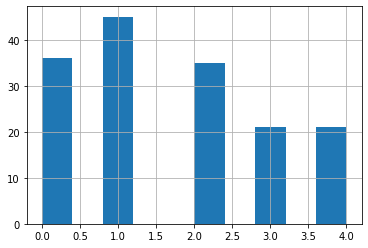

In [75]:
# verkoop_order_df['product_id'] = verkoop_order_df['verkoop_order_datum'].apply(lambda x: random.randint(0,3))


if show_intermediate_results == True:
    verkoop_order_df['verkocht_product_id'].hist()

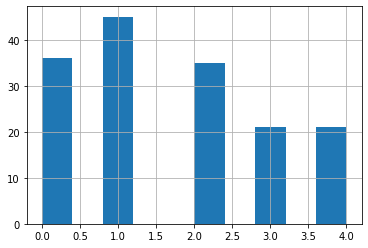

In [76]:
# verkoop_order_df['product_id'] = verkoop_order_df['verkoop_order_datum'].apply(lambda x: random.randint(0,3))
# Solve Issue #5

if show_intermediate_results == True:
    verkoop_order_df['verkocht_product_id'].hist()

In [77]:
machine_data ={
    # for issue #14 added energie_verbruik
    0:{'machine_type':'boor'},
    1:{'machine_type':'frees'},
    2:{'machine_type':'buig'},
    3:{'machine_type':'CNC'},
    4:{'machine_type':'snij'},
    5:{'machine_type':'boor'},
    6:{'machine_type':'stans'},
    7:{'machine_type':'CNC'},
    8:{'machine_type':'snij'},
    9:{'machine_type':'CNC'},
    10:{'machine_type':'CNC'},
    11:{'machine_type':'CNC'},
    12:{'machine_type':'boor'},
    13:{'machine_type':'assemblage'}   # abuse machine object to add an assembly step for issue #13
    }
machine_df = pd.DataFrame.from_dict(machine_data, orient='index').reset_index()
machine_df.columns = ['machine_id','machine_type']


machine_df.index.rename('machine_id', inplace=True)


if show_intermediate_results == True:
    
    print(machine_df.head(10) )

            machine_id machine_type
machine_id                         
0                    0         boor
1                    1        frees
2                    2         buig
3                    3          CNC
4                    4         snij
5                    5         boor
6                    6        stans
7                    7          CNC
8                    8         snij
9                    9          CNC


In [78]:
# werkorder_df = pd.DataFrame(data=(random.randint(0,25, size=(n_verkoop_order_df, 2))), columns=['klant_id','verkoop_order_datum'])
werkorder_df = verkoop_order_df.copy()
werkorder_df.reset_index(inplace = True)
werkorder_df.index.rename('werkorder_id', inplace=True)
werkorder_df['werkorder_start_datum'] = werkorder_df['verkoop_order_datum'].apply(lambda x: x+timedelta(days=random.randint(0,2)))
werkorder_df['werkorder_eind_datum'] = werkorder_df['verkoop_order_datum'].apply(lambda x: x+timedelta(days=random.randint(3,10)))


werkorder_df.drop(['klant_id','verkoop_order_datum'], axis=1, inplace=True)

if show_intermediate_results == True:
    print('n_werkorder_df : {}\n'.format(len(werkorder_df)))
    print(werkorder_df.head(10))

n_werkorder_df : 158

              verkoop_order_id  verkocht_product_id  verkocht_product_aantal  \
werkorder_id                                                                   
0                            0                    2                        1   
1                            1                    0                        1   
2                            2                    2                        1   
3                            3                    2                        1   
4                            4                    1                        1   
5                            5                    0                        1   
6                            6                    2                        1   
7                            7                    1                        1   
8                            8                    2                        1   
9                            9                    2                        1   

             werk

In [79]:
# Map products with a randaom amount of machines using both dataframes

def product_machines_map(product_df, machine_df):
    dictionary={}
    inner_dict={}
    machine_types=machine_df.machine_type.unique()
    machine_types=list(machine_types)[::-1]
    machine_types=['stans', 'snij', 'buig', 'frees', 'CNC', 'boor']
    print('\nHard code machine types and order: {}\n'.format(machine_types))
    product_ids=list(product_df.product_id.unique())
    step=0
    
    for prod_id in product_ids:
        low=random.randint(0,2)
        high=random.randint(4,6)
 #       print(high)
        for step in range(low,high):
            inner_dict[step]=machine_types[step]
        # add assemblage step (as a 'machine') in the mapping for issue #13
        inner_dict[len(inner_dict.keys())]='assemblage'
        dictionary[prod_id]=inner_dict
        inner_dict={}
    
    return dictionary

if show_intermediate_results == True:
    print(product_machines_map(product_df, machine_df))


Hard code machine types and order: ['stans', 'snij', 'buig', 'frees', 'CNC', 'boor']

{0: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'CNC', 5: 'assemblage'}, 1: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'assemblage'}, 2: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'CNC', 5: 'assemblage'}, 4: {1: 'snij', 2: 'buig', 3: 'frees', 4: 'assemblage'}, 3: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'CNC', 5: 'assemblage'}}


In [80]:
product_machines_map(product_df, machine_df)


Hard code machine types and order: ['stans', 'snij', 'buig', 'frees', 'CNC', 'boor']



{0: {1: 'snij', 2: 'buig', 3: 'assemblage'},
 1: {1: 'snij', 2: 'buig', 3: 'frees', 4: 'assemblage'},
 2: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'assemblage'},
 4: {1: 'snij', 2: 'buig', 3: 'assemblage'},
 3: {0: 'stans', 1: 'snij', 2: 'buig', 3: 'frees', 4: 'CNC', 5: 'assemblage'}}

In [81]:
def zipper(l1, l2):
    return [list(l) for l in zip(l1, l2)]

In [82]:
def pick_random_machine(machine_type, machine_df):
    machine_id=0
    
    rand_pick=machine_df[machine_df['machine_type'] == machine_type]['machine_id']
    machine_id=rand_pick.iloc[random.randint(0, len(rand_pick))]
    
    return machine_id

# machine_df.sort_values('machine_type')

In [83]:
def bewerkingstijd(product_id, machine_id):
    bewerking_tijd = 1.3
    
    producten=list(product_df.index)
    machines=list(machine_df.index)
#    machines=list(machine_df.sort_values('machine_type').index)
    
#    matrix=random.randint(low=1, high=10, size=(len(producten), len(machines)))
    # added additional column for issue #13 to extend matrix object
    matrix=[[4, 9, 2, 9, 8, 8, 5, 15, 6, 12, 8, 6, 2, 15],
            [3, 8, 1, 11, 5, 2, 4, 13, 3, 15, 6, 7, 2, 14],
            [2, 6, 1, 12, 9, 7, 5, 16, 8, 16, 5, 4, 4, 13],
            [3, 7, 1, 10, 5, 2, 4, 13, 3, 16, 6, 7, 2, 10],
            [3, 8, 1, 11, 5, 2, 5, 16, 8, 16, 5, 4, 4, 9]]
    
    df=pd.DataFrame(data=matrix, columns=machines)

    bewerking_tijd=df[machine_id].iloc[product_id]
    
    return round(bewerking_tijd)

if show_intermediate_results == True:
    n,i =(1,4)
    print('\nproduct_id: {}\t machine_id: {}\n'.format(list(product_df.index)[n], list(machine_df.index)[i]))
    print(bewerkingstijd(list(product_df.index)[n], list(machine_df.index)[i]))


product_id: 1	 machine_id: 4

5


In [84]:
def insert_row_in_df(row_number, df, row_value):
    if row_number > df.index.max()+1: 
        print("Invalid row_number. Did not insert row into dataframe.")
        df_result=df
    else:
        # Slice the upper half of the dataframe 
        df1 = df[0:row_number] 

        # Store the result of lower half of the dataframe 
        df2 = df[row_number:] 

        # Inser the row in the upper half dataframe 
        df1.loc[row_number]=row_value 

        # Concat the two dataframes 
        df_result = pd.concat([df1, df2]) 

        # Reassign the index labels 
        df_result.index = [*range(df_result.shape[0])] 
   
    # Return the updated dataframe 
    return df_result 

In [85]:
def create_routes(werkorder_df, machine_df):
    columns=['werkorder_id','machine_id','step_id','bewerking_tijd']
    routes=pd.DataFrame(columns=columns)
    prod_machi_map=product_machines_map(product_df, machine_df)
    
    step=0
    machine='-'
    bewerking_tijd=1
    
    for wo in list(werkorder_df.index):
        
        # select a product_id for a given werkorder wo
        p=werkorder_df.iloc[wo]['verkocht_product_id'] # solve Issue #5 product_id
        
        # per step in the available steps/'keys' of a product
        for step in prod_machi_map[p].keys():
            
            # return the machine_id based on the machine_type
            
            # for issue #13. But don't use 'assemblage' to pick as random machine
            #   Temp remove 'assemblage' step from machine object 
            if prod_machi_map[p][step] != 'assemblage':
                machine=pick_random_machine(prod_machi_map[p][step], machine_df) 

            # for issue #13. Use only single existing 'machine' for 'assemblage' step
            else: machine=machine_df[machine_df['machine_type'] == 'assemblage']['machine_id'].values[0]
            
            bewerking_tijd=bewerkingstijd(p,machine)
            routes=routes.append(dict(zipper(columns, [wo, machine, step, bewerking_tijd])), ignore_index=True)
        
        # add another step for assembly at the end of a route dictionary
    
    return routes
    
# df=create_routes(werkorder_df[:20], machine_df)
# df.head(20)

In [86]:
def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

In [87]:
route_df = create_routes(werkorder_df, machine_df)
route_df['bewerking_tijd_cumsum'] = route_df[['werkorder_id', 'step_id','bewerking_tijd']].groupby(['werkorder_id', 'step_id'], \
                                                     sort=True).sum().groupby(level=0).cumsum().reset_index(inplace=False)['bewerking_tijd']
route_df['bewerking_tijd_cumsum_timedelta'] = route_df['bewerking_tijd_cumsum'].apply(lambda x: x)

if show_intermediate_results == True:
    print(route_df.head(30))


Hard code machine types and order: ['stans', 'snij', 'buig', 'frees', 'CNC', 'boor']

   werkorder_id machine_id step_id bewerking_tijd  bewerking_tijd_cumsum  \
0             0          6       0              5                      5   
1             0          4       1              9                     14   
2             0          2       2              1                     15   
3             0          1       3              6                     21   
4             0         13       4             13                     34   
5             1          6       0              5                      5   
6             1          4       1              8                     13   
7             1          2       2              2                     15   
8             1          1       3              9                     24   
9             1          7       4             15                     39   
10            1         13       5             15                     54   
1



		Werkorder doorloop tijd



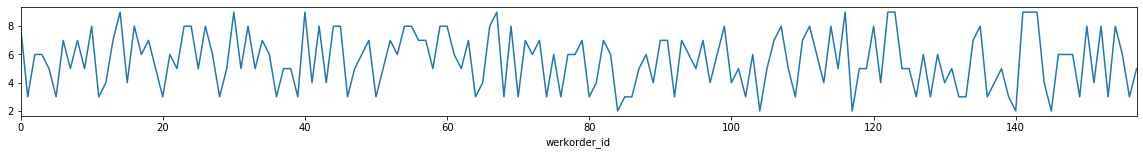

In [88]:
werkorder_df['werkorder_doorlooptijd'] = werkorder_df['werkorder_eind_datum']-werkorder_df['werkorder_start_datum']
# corrected to bypass Timestamps not being usefull in Power BI. Issue #2
werkorder_df['werkorder_doorlooptijd'] = werkorder_df['werkorder_doorlooptijd'].apply(lambda x: x.days)
werkorder_df['werkorder_maand_nummer'] = werkorder_df['werkorder_eind_datum'].apply(lambda x: x.isocalendar()[2])
werkorder_df['werkorder_doorlooptijd'].plot(figsize=(20,2))



print('\n\n\t\tWerkorder doorloop tijd\n')
#werkorder_df.drop(labels=['werkorder_doorlooptijd'], axis=1, inplace=True)

In [89]:
fig = px.line(werkorder_df.sort_values("werkorder_maand_nummer", ascending=False),  y="werkorder_doorlooptijd", color='werkorder_maand_nummer')
fig.show( )

In [90]:
fig = px.line(werkorder_df.sort_values("werkorder_doorlooptijd", ascending=False),  y="werkorder_doorlooptijd", color='werkorder_maand_nummer')
fig.show()

In [91]:
klant__verkoop_order_df = klant_df.join(verkoop_order_df.set_index('klant_id'), lsuffix='le_', rsuffix='re_')

if show_intermediate_results == True:    
    print(klant__verkoop_order_df.head(8))

          klant_id  achternaam voornaam geslacht      Woonplaats  \
klant_id                                                           
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
0                8  Luijn, van   Noëlle        V  Bergen op Zoom   
1               79   Oldenhuis   Feline        V         Stokkum   

         Gemeente|Naam  Gemeente|Code  Provincie|Naam verkoop_order_datum  \
klant_id                                                                    
0          BergenopZoom         GM0748  Noord-Brabant          2019-05-16   
0          BergenopZoom         GM0748  Noord-Brabant          2019-07-25   
0          

In [92]:
def save_dateframes(dataframes_list):
    
    for df in dataframes_list:
        # Solving issue #7
        try:
            if globals()[df].index.name == None:
                old=globals()[df].index.name
                globals()[df].index.name=str(df).replace('_df', '')+'_id'
                print('{} >> {}'.format(old, globals()[df].index.name ))
        except: 
            print('Unable to change index column name for dataframe {}.'.format(df))

                
        try:
            
            globals()[df].to_csv(path_or_buf=str(df)+'.csv', sep='|')
            globals()[df].to_csv(path_or_buf=str(df)+'.tsv', sep='\t')
        except:
            print('Failed to save {} to TSV file.'.format(df))

In [105]:
if create_source_files:
    save_dateframes(dataframes_list)

In [151]:
save_dateframes(['onderdelen_df'])

In [152]:
globals()['onderdelen_df'].index.name

'__id'